In this notebook, we shall use a single-cell RNAseq data to deconvolve a bulk RNAseq data **using minimal set of steps**.

This notebook uses the same dataset as in bulkRNAseq.ipynb tutorial.

In [1]:
import dissect #import DISSECT

In [2]:
# Get config file and update with required changes

config = dissect.config
config["experiment_folder"] = "tutorial_tldr" # folder to store results
config["simulation_params"]["scdata"] = "data/scRNAseq/sampled_100_data8k.h5ad" #  Path to single cell data
config["simulation_params"]["type"] = "bulk" # Type of simulation. bulk or ST
config["simulation_params"]["celltype_col"] = "cell_type" # Cell type column name in .obs of single-cell data
config["deconv_params"]["test_dataset"] = "data/bulkRNAseq/bulk_gse120502.txt"

Starting simulations
Number of batches in single-cell data is 1. If this is incorrect, please specify name of the batch column as in the single-cell data object (.obs)


100%|██████████████████████████████████████████████████████████| 6000/6000 [01:47<00:00, 55.57it/s]


-----

Preprocessing datasets
Removing genes which have less than 0.1 variance in their expressions.
test dataset has 16872 distinct and variable genes.
simulated dataset has 13669 distinct genes.
There are 11505 common genes between simulated and test dataset.
Saving numpy files.
Done.
-----

Estimating cell type fractions
Loading prepared datasets...
Starting training model 0


step: 5000| loss: 0.0101: 100%|████████████████████████████████| 5000/5000 [10:26<00:00,  7.98it/s]


Starting training model 1


step: 5000| loss: 0.0101: 100%|████████████████████████████████| 5000/5000 [10:28<00:00,  7.96it/s]


Starting training model 2


step: 5000| loss: 0.0141: 100%|████████████████████████████████| 5000/5000 [10:26<00:00,  7.98it/s]


Starting training model 3


step: 5000| loss: 0.0142: 100%|████████████████████████████████| 5000/5000 [10:27<00:00,  7.97it/s]


Starting training model 4


step: 5000| loss: 0.0108: 100%|████████████████████████████████| 5000/5000 [10:23<00:00,  8.02it/s]


Predictions are saved to tutorial_tldr/dissect_fractions.txt
-----

Estimating cell type-specific gene expression per sample
Estimating expression of 11529 common genes
Preparing training datasets.


100%|██████████████████████████████████████████████████████████████| 55/55 [34:27<00:00, 37.59s/it]


Estimated gene expression per cell type is saved at tutorial_tldr/est_expression_layered.h5ad and is included in the layers attribute of the anndata object.
Estimated gene expression per cell type for all samples is saved at tutorial_tldr/est_expression.h5ad, corresponding samples are in sample attribute of the anndata.obs.


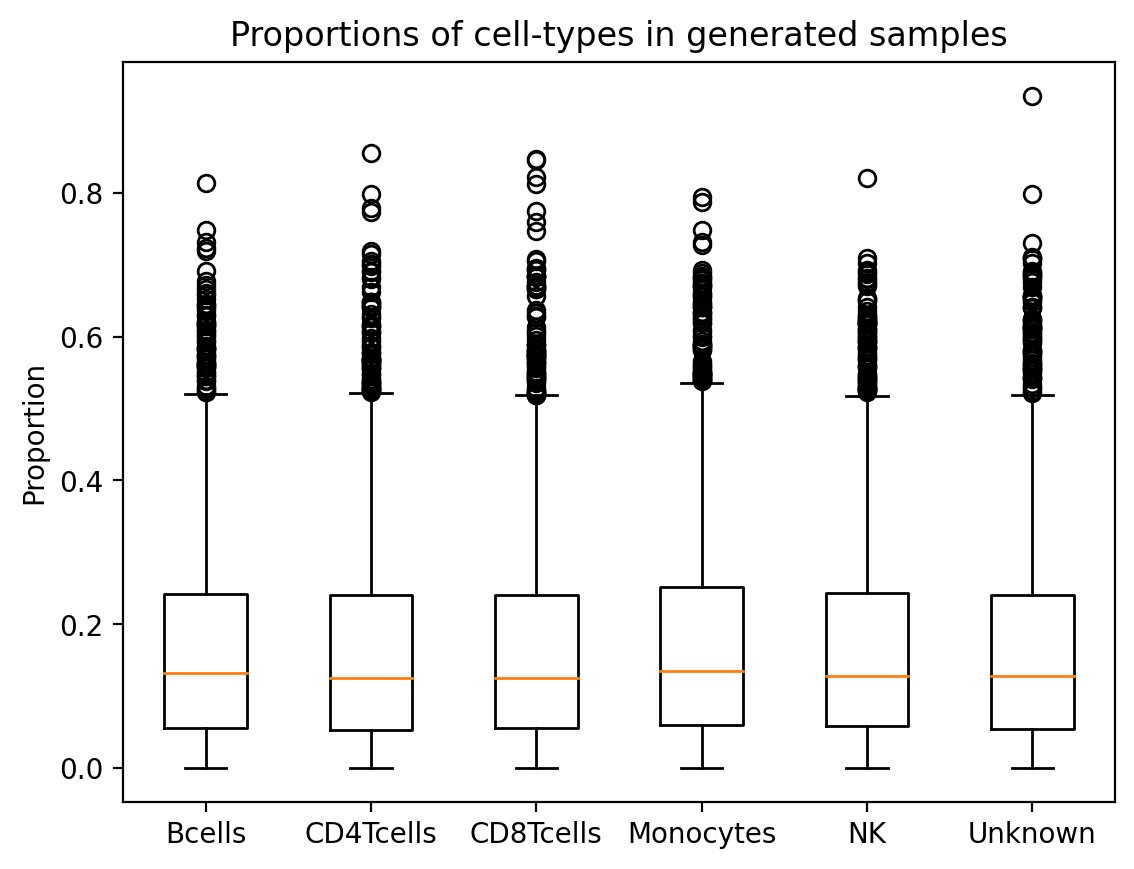

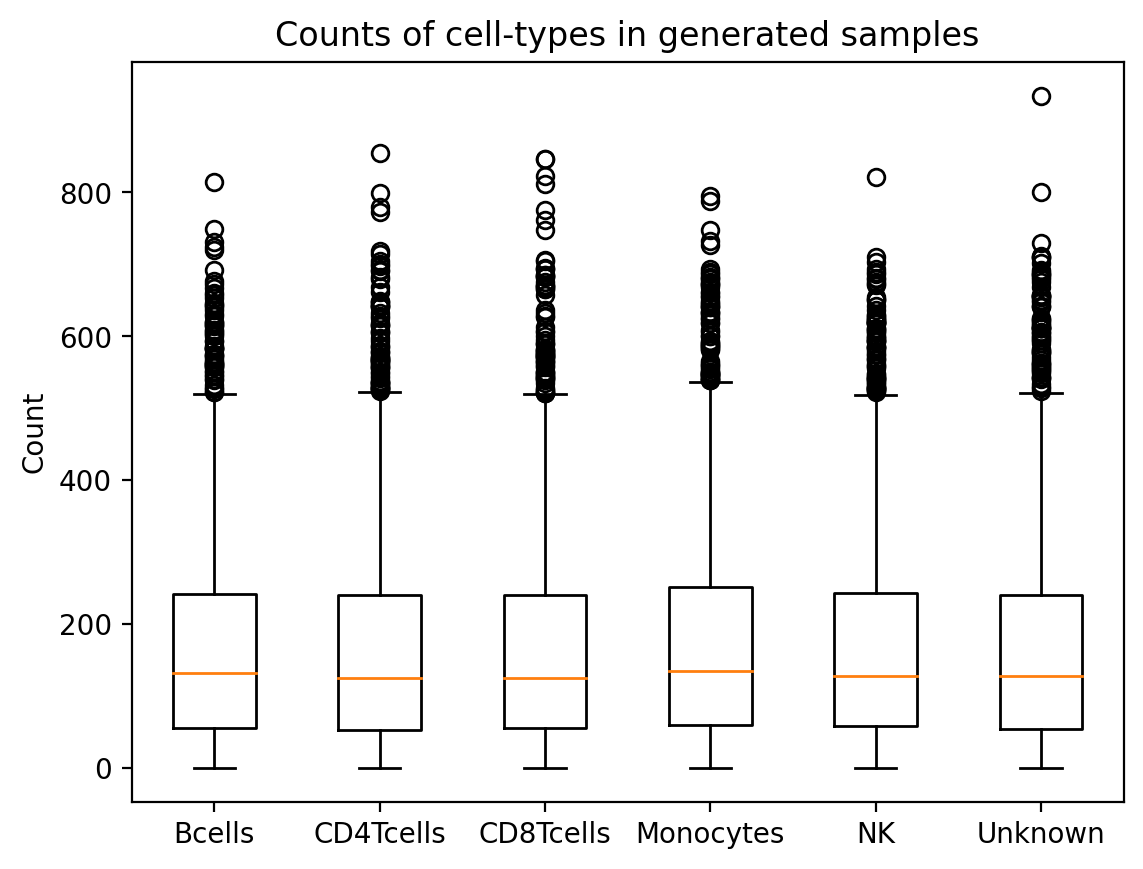

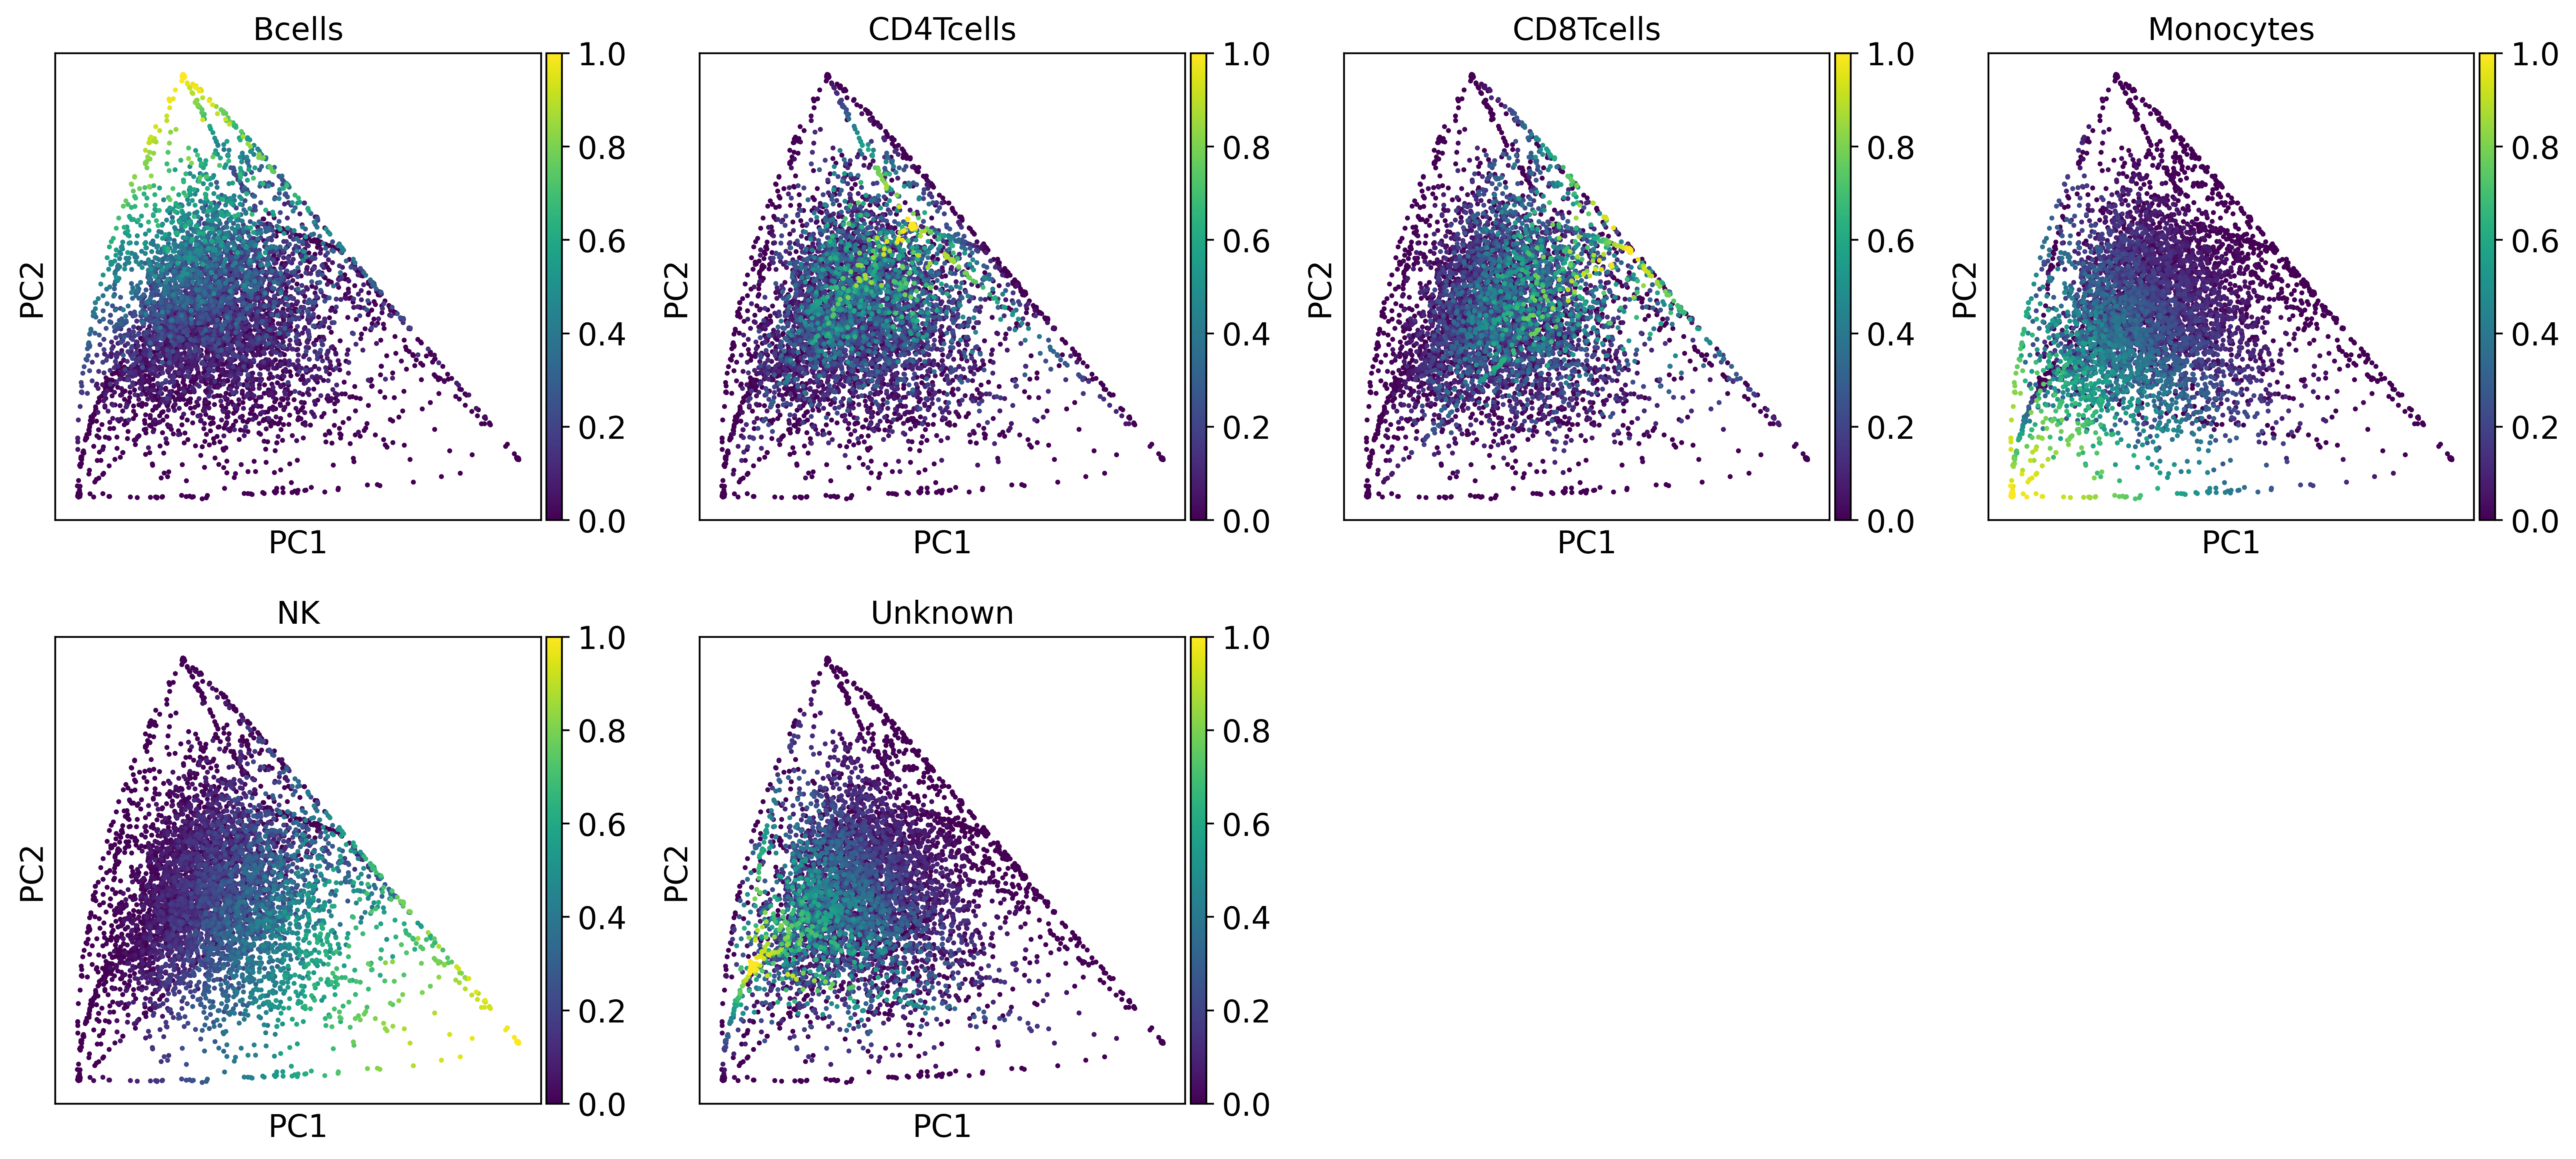

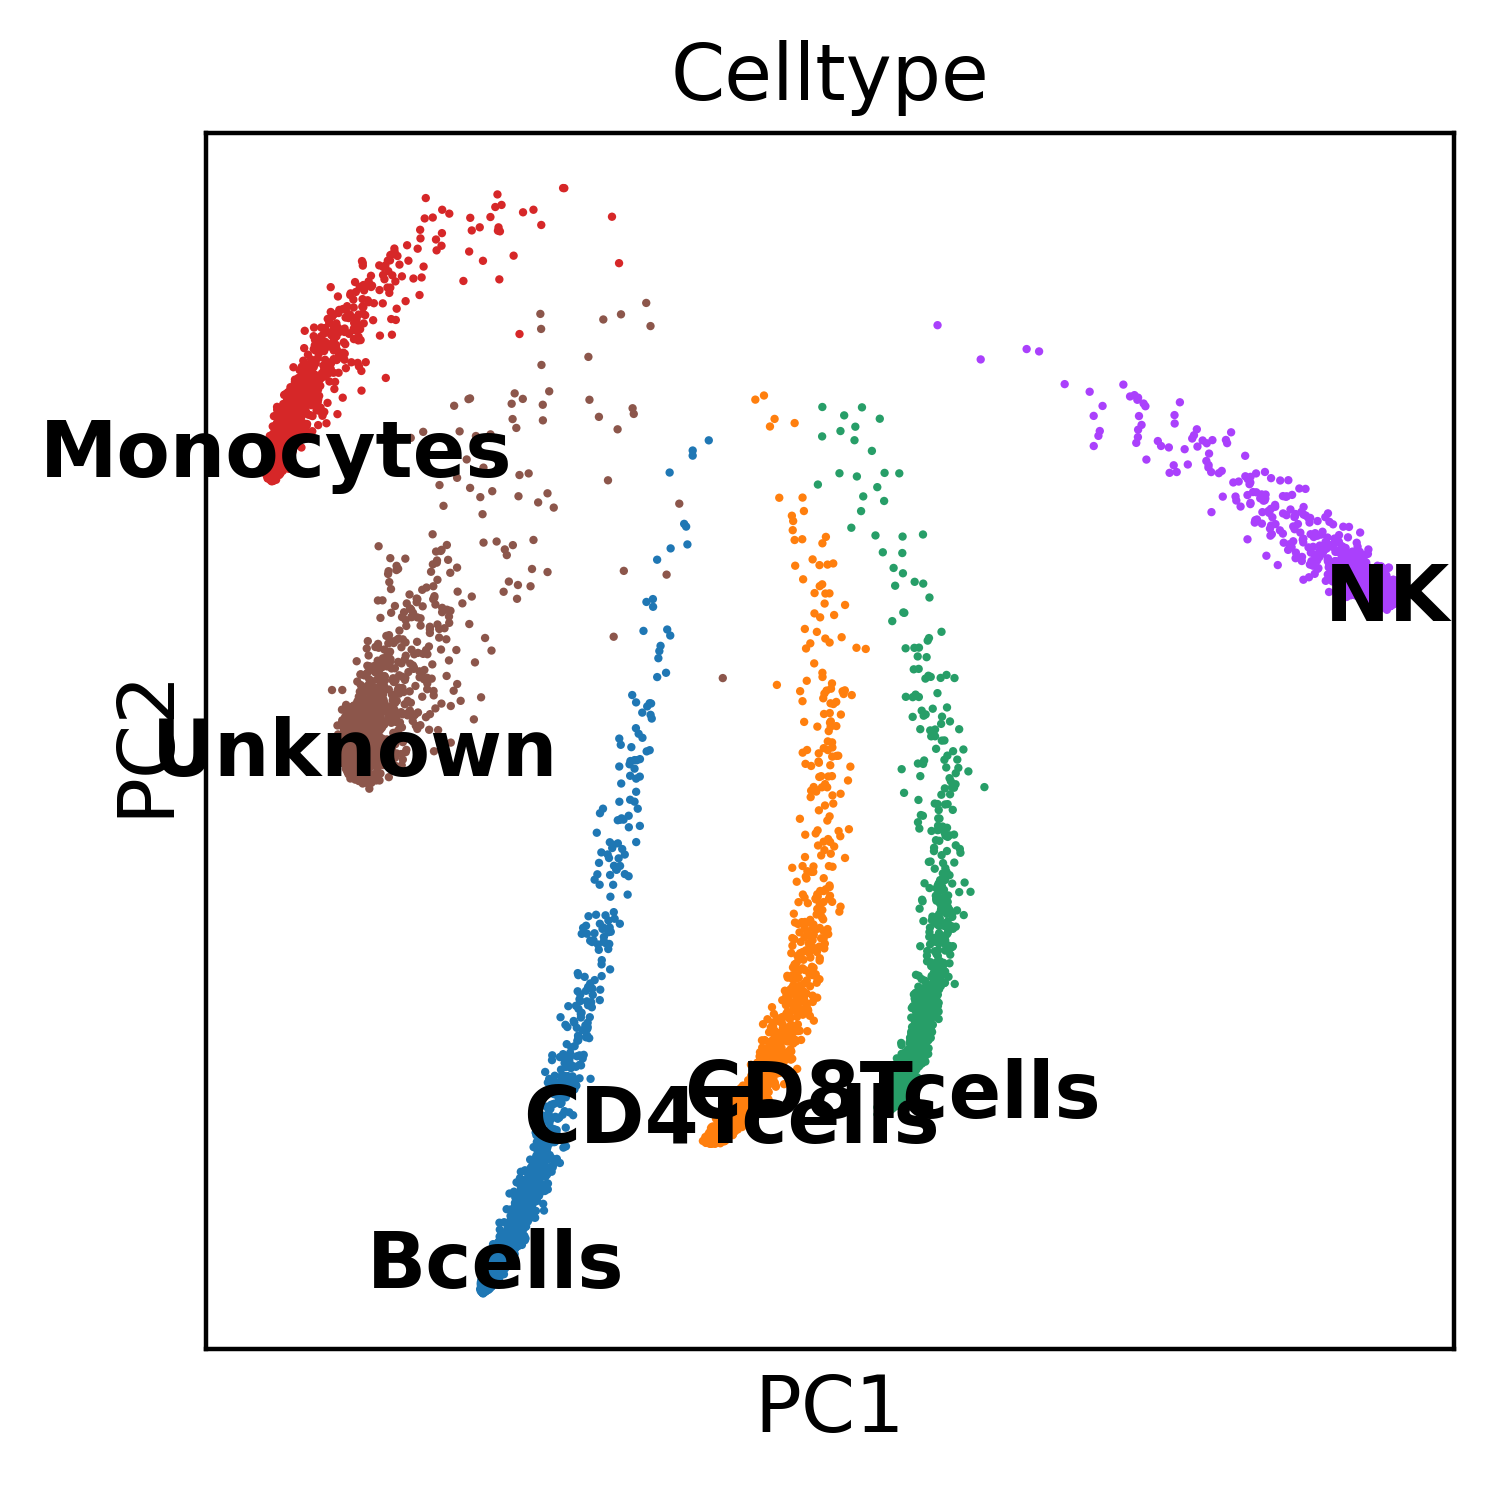

In [3]:
# run dissect
dissect.run_dissect(config)

In [5]:
import os
import pandas as pd
result_path = os.path.join(config["experiment_folder"],
                          "dissect_fractions.txt")

df = pd.read_table(result_path, index_col=0)
df.head()

Bcells  CD4Tcells  CD8Tcells  Monocytes        NK   Unknown
T63_LPS_FC1_4    0.050518   0.270509   0.339228   0.150402  0.099190  0.090153
T81_LPS_FC1_4    0.120564   0.335213   0.265350   0.116297  0.060124  0.102452
T104_LPS_FC1_4   0.041854   0.475849   0.260466   0.081914  0.066639  0.073278
T4_GARD_BATCH_2  0.082372   0.348196   0.327580   0.073475  0.091737  0.076641
K47_LPS_FC1_4    0.070813   0.304194   0.265212   0.175816  0.081244  0.102720

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.3) # set figure params

## Show cell type composition of each sample

Text(0, 0.5, 'Estimate')

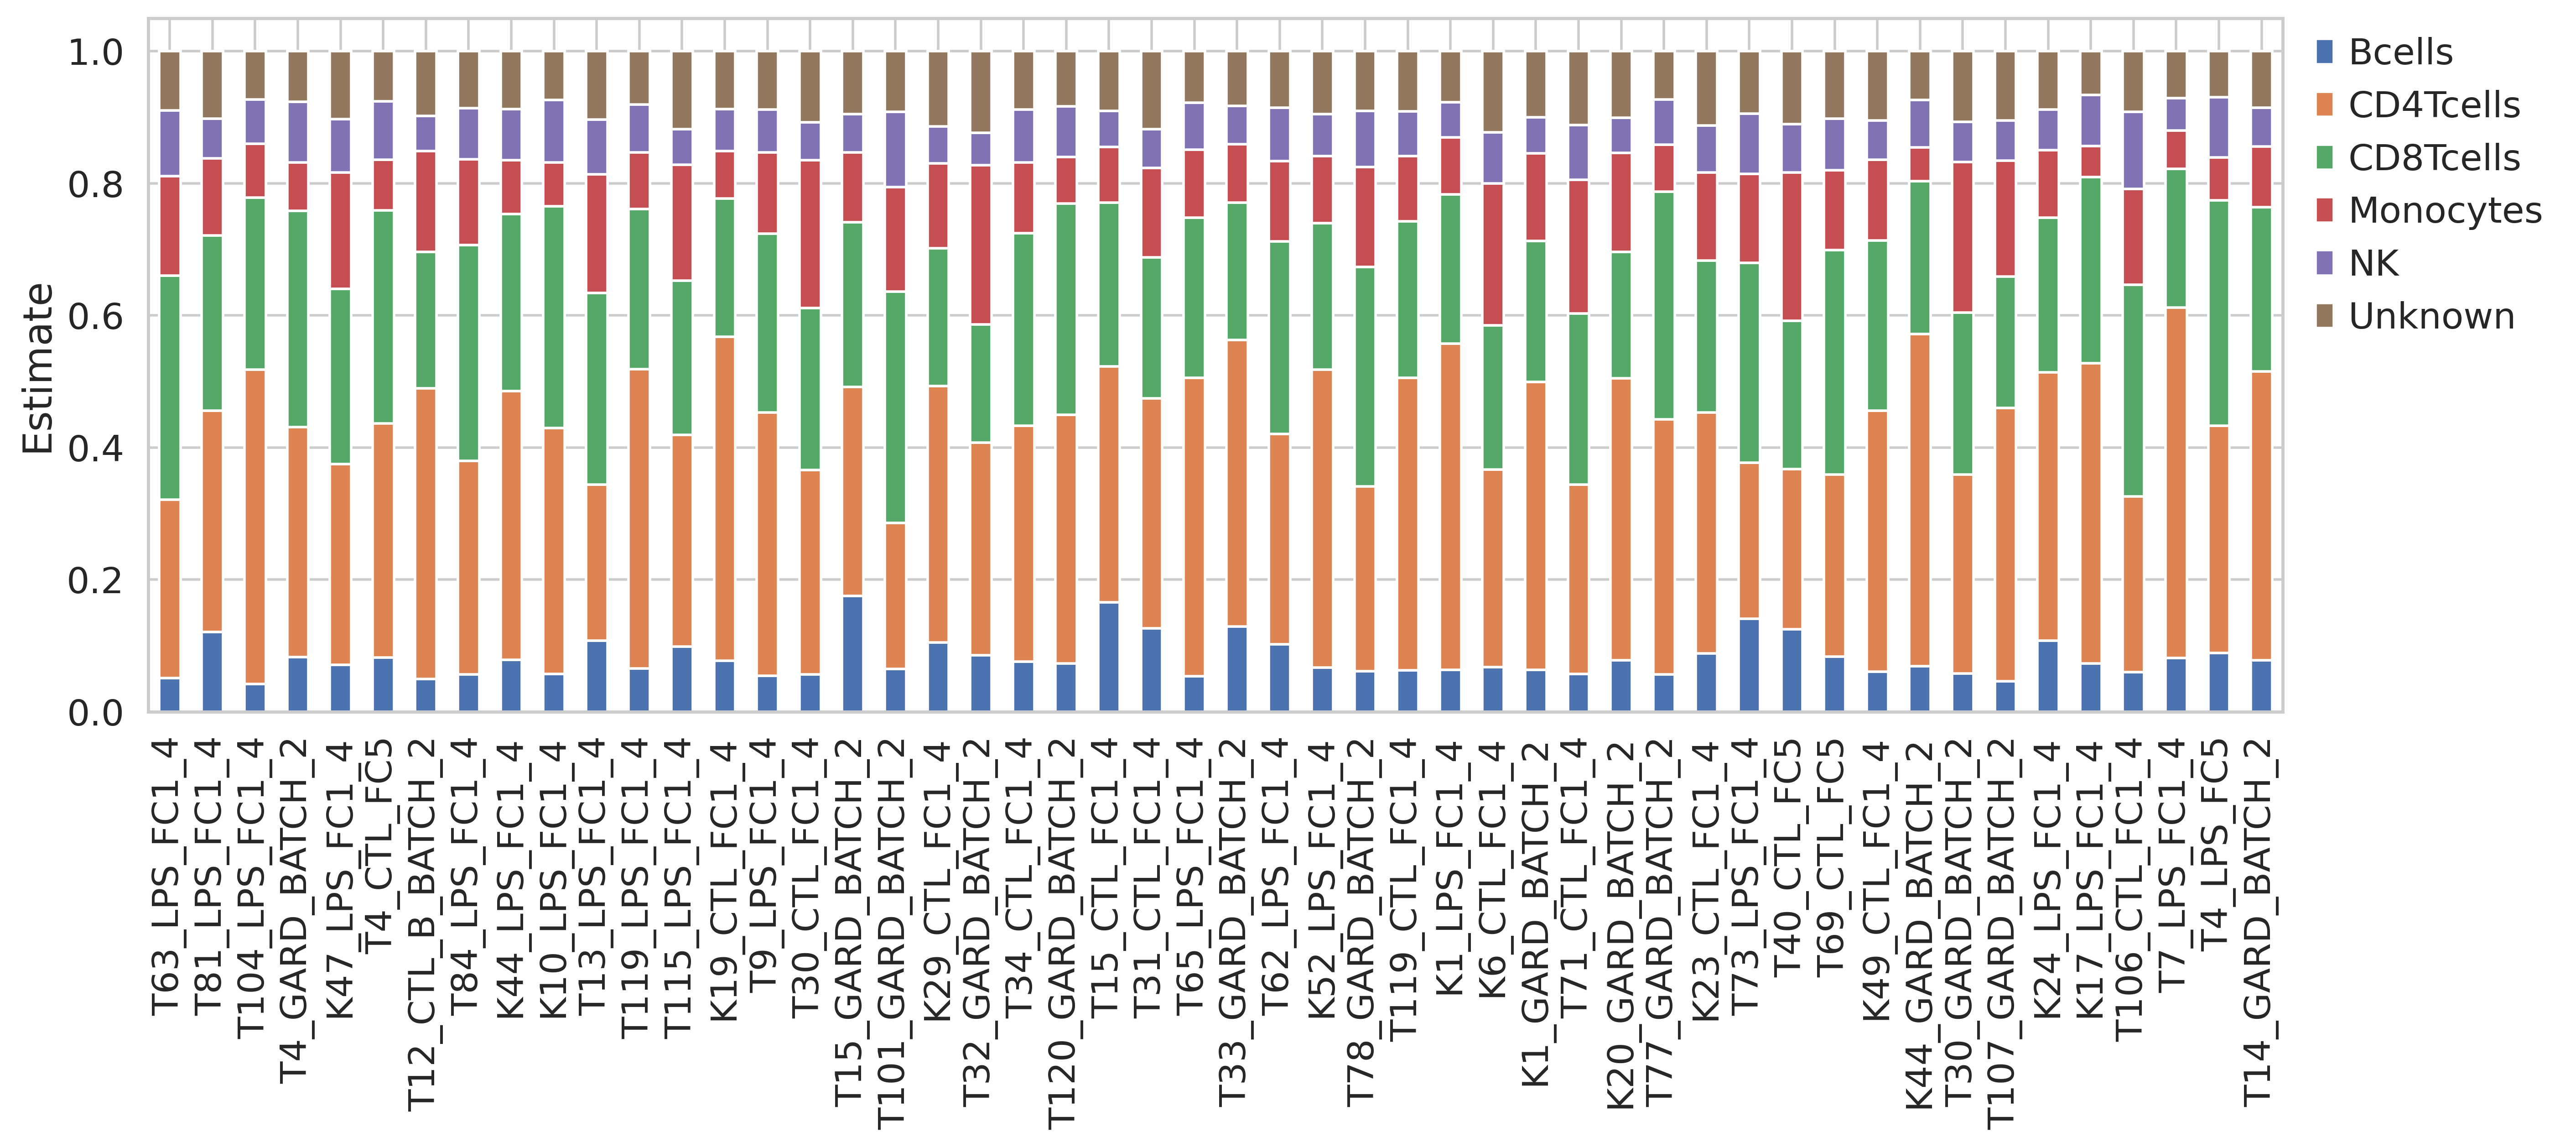

In [8]:
show_samples = 50 # We will show composition of the first 50 samples. 
# show estimates of first 50 samples. More gets hard to see.
df.iloc[0:show_samples,:].plot(kind='bar', stacked=True, figsize=(15,5))
plt.legend(bbox_to_anchor=(1,1.02), frameon=False)
plt.ylabel("Estimate")

## Show distribution of cell type proportions

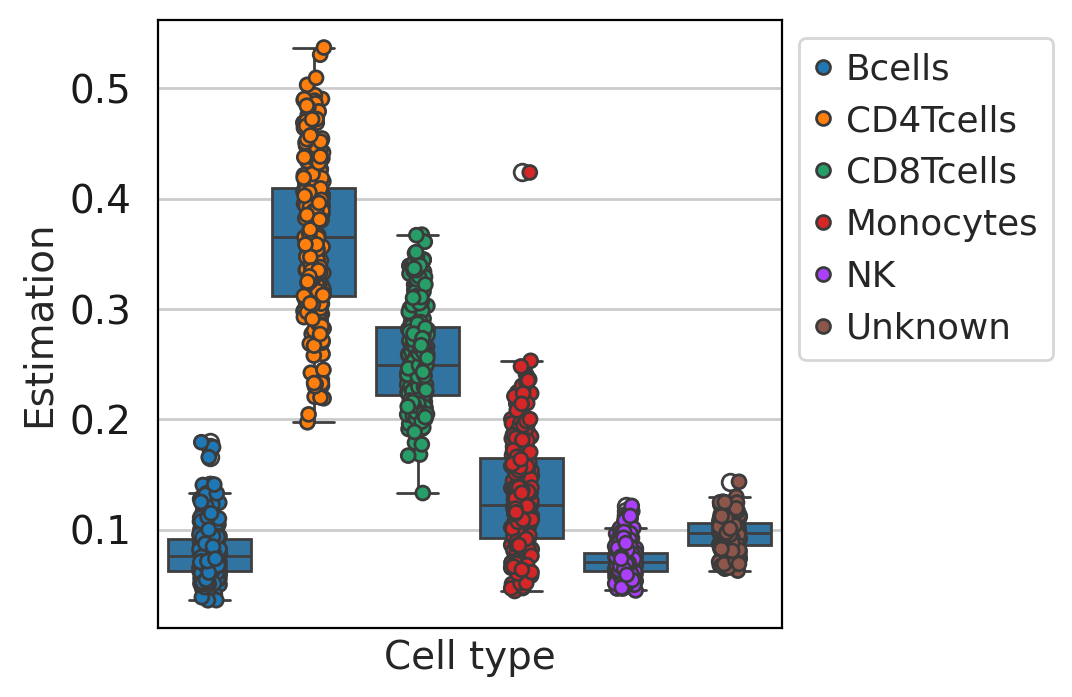

In [11]:
import scanpy as sc
sc.set_figure_params(dpi=100)
melted = df.melt(var_name="Cell type", value_name="Estimation")
ax = sns.boxplot(data=melted, x="Cell type", y="Estimation")

sns.stripplot(data=melted, x="Cell type", y="Estimation", linewidth=1, edgecolor="gray", ax=ax, hue="Cell type", legend=True)
ax.set_xticks([],[])
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Let's load our results for gene expression estimation and see how it is structured, how we can visualize it and use it for downstream analysis.

In [13]:
adata_est = sc.read(os.path.join(config["experiment_folder"], "est_expression.h5ad"))
print(adata_est)

AnnData object with n_obs × n_vars = 1500 × 11529
    obs: 'sample', 'cell_type'
    layers: 'scaled_counts'


Since the data object is compatible with Scanpy, default Scanpy functions can be used. Below we'll show an example.

## show expression of highly variable genes

In [23]:
n_hvg = adata_est.var[adata_est.var.highly_variable].sort_values(by="dispersions",
                                                        ascending=False).index[0:200]

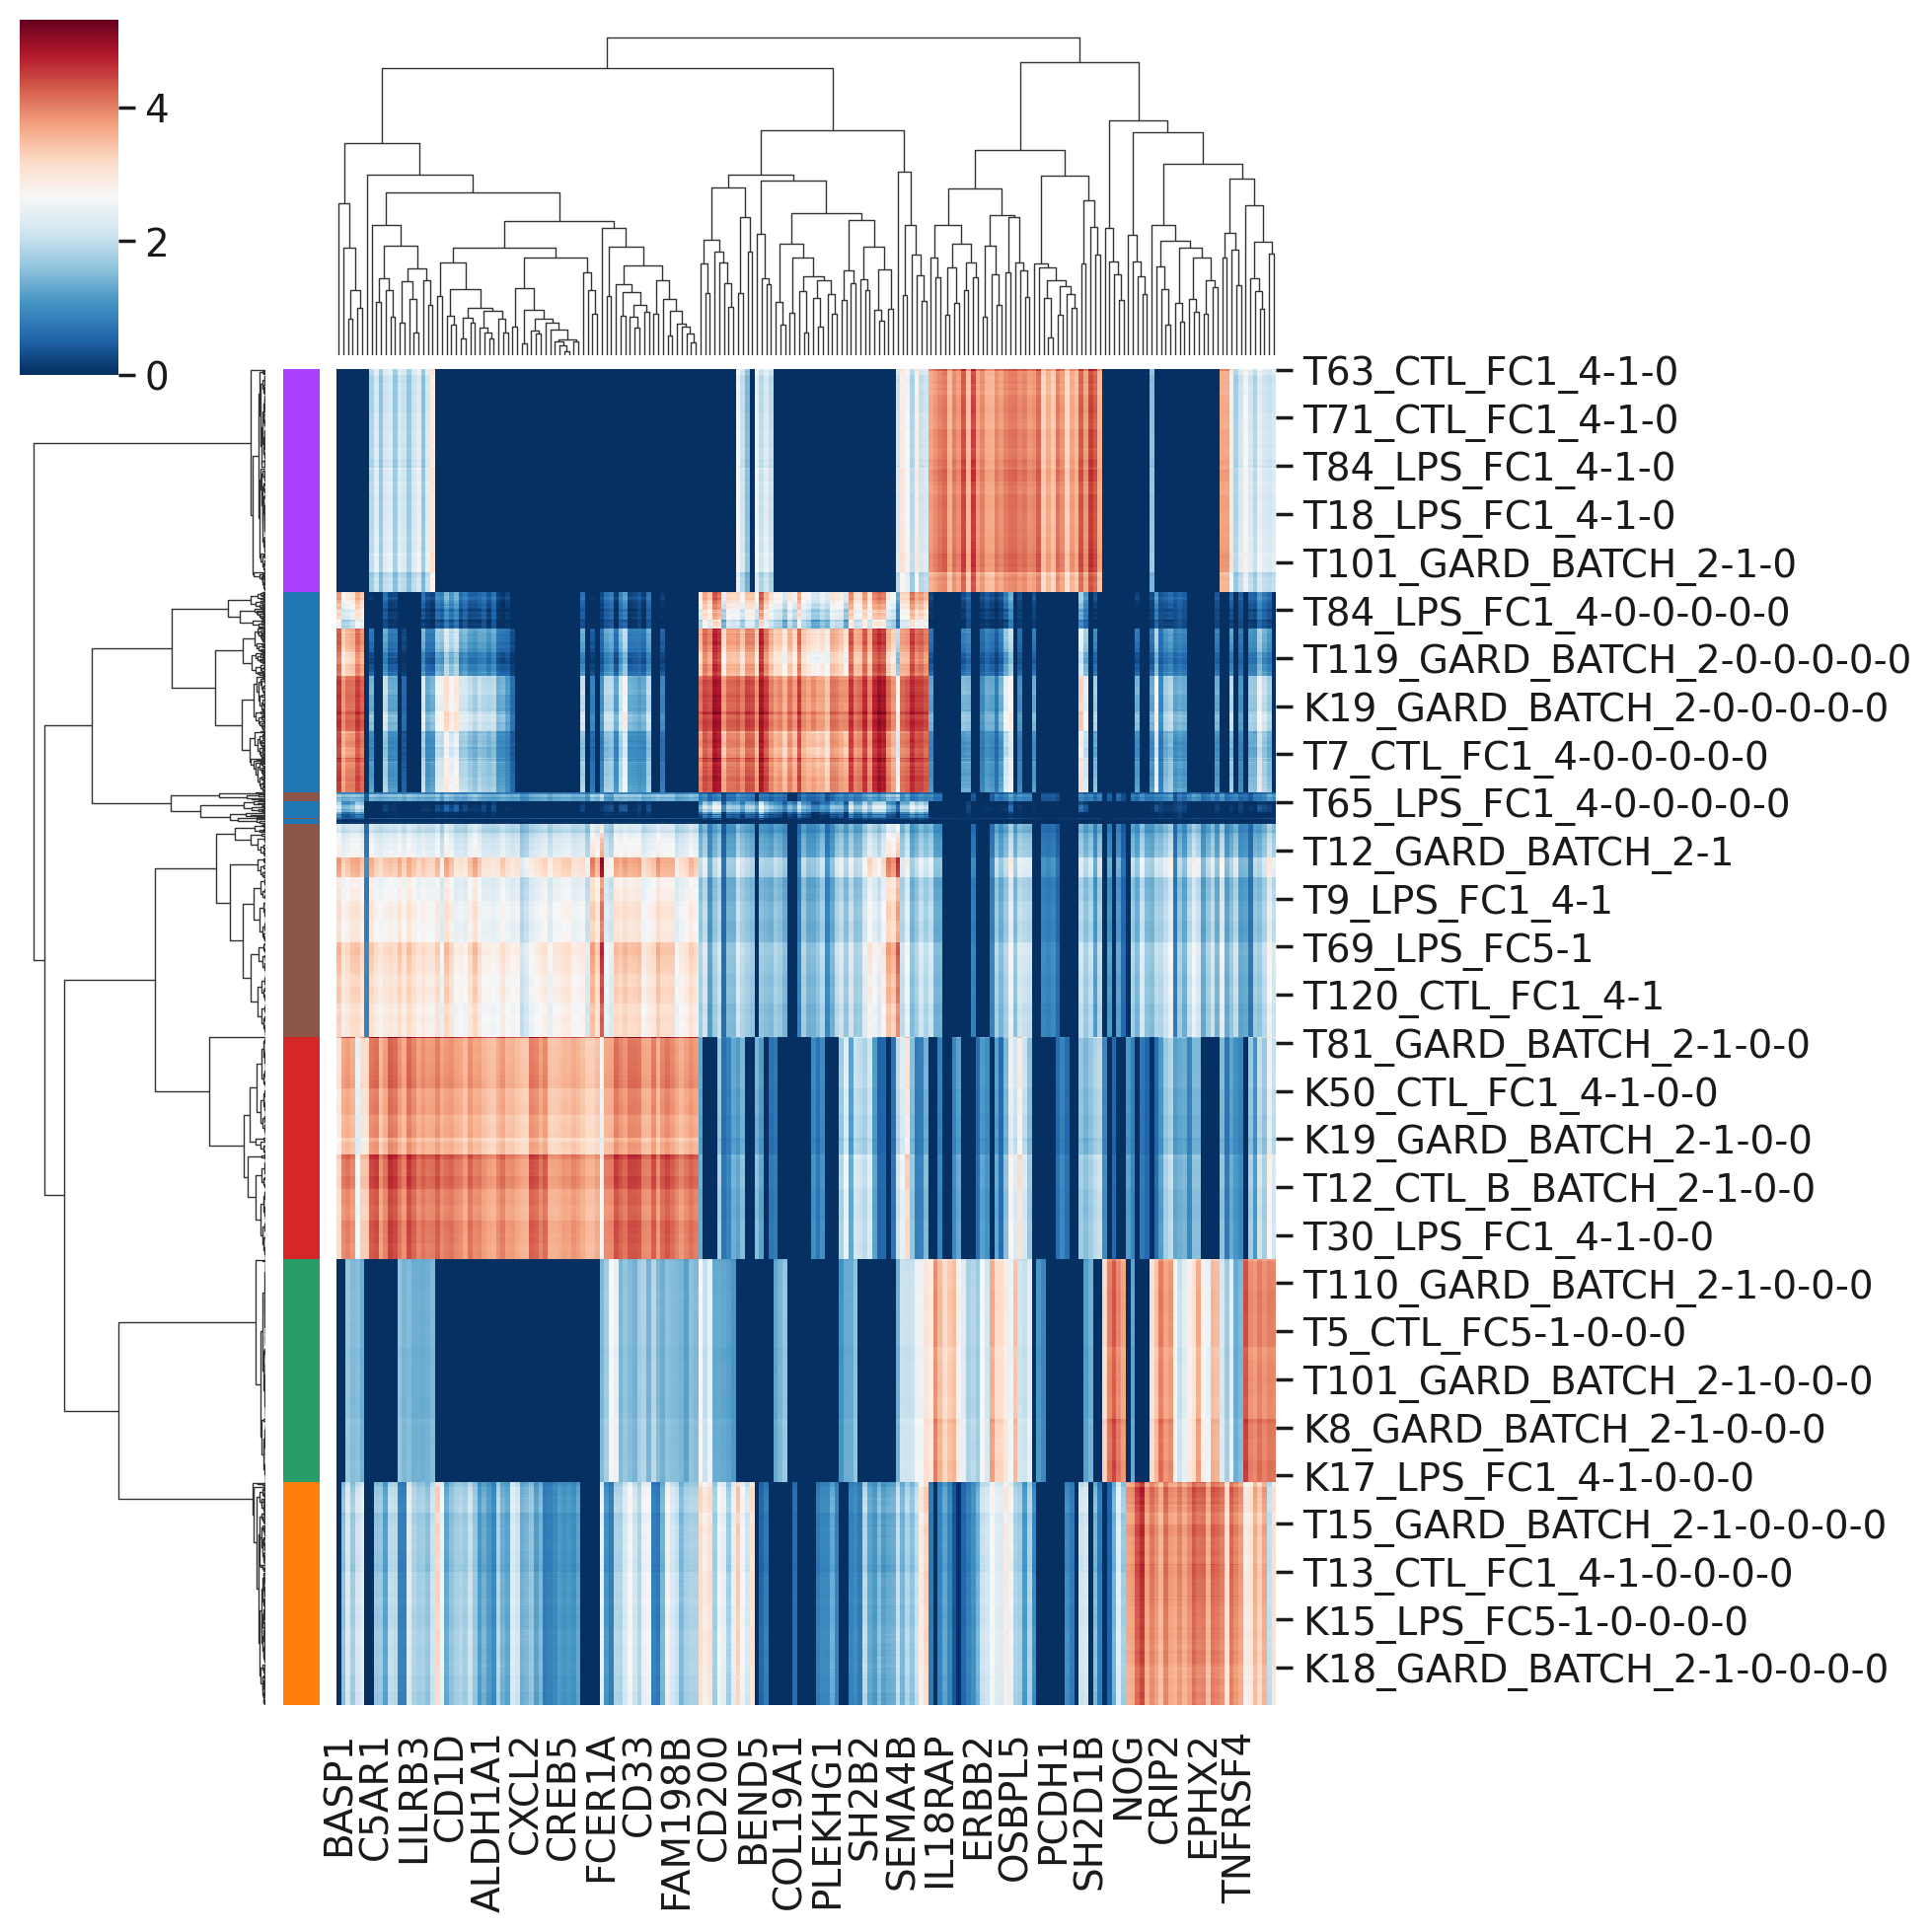

In [29]:
sc.pl.clustermap(adata_est[:, n_hvg], cmap="RdBu_r", obs_keys="cell_type")